# Import all Required Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib widget

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from tensorflow.keras.initializers import GlorotUniform, HeNormal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.impute import KNNImputer

# Prepare the Dataset

Import and Inspect the Dataset

In [3]:
# Read and store the Almond data as a pandas dataframe
original_almond_dataset = pd.read_csv('Almond.csv')

visualize = False

if visualize:
    # Visualize the Data
    print('Display the first 5 rows of the dataset:')
    display(original_almond_dataset.head())
    print('Display a summary of the dataset:')
    display(original_almond_dataset.describe())

    # Missing Values Visualization
    plt.figure(1)
    plt.clf()
    sns.heatmap(original_almond_dataset.isnull(), cbar=False, cmap='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Handle all dataset missing values

In [4]:
# Read and store the Almond data as a pandas dataframe
almond_dataset = pd.read_csv('Almond.csv')

#___________________________________________________________________________________________________________________________
# The length, width and thickness will be replaced by their mean values, using their 500 nearest neigbours

# Fill the length, width and thickness empty values using the K Nearest Neighbors Imputer
length_imputer = KNNImputer(n_neighbors=20)
# Which columns should be used to impute: (# All the non-dependent features that have missing values)
imputing_features = ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Solidity', 'Compactness', 'Extent', 'Convex hull(convex area)']

# imputing_features = ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio',
#                      'Eccentricity', 'Extent', 'Convex hull(convex area)']

# The dataset that will be used to impute:
impute_data = almond_dataset[imputing_features]
# Fit and transform the imputer to fill missing values
almond_dataset[imputing_features] = length_imputer.fit_transform(impute_data)

#___________________________________________________________________________________________________________________________
# Fill the dependent variables using the length and width values calculated using the KNN Imputer

# Find the mean values of the Roundness, Aspect Ratio, and Eccentricity columns, for cases where division by zero, or a negative square root occurs
mean_roundness = np.mean(almond_dataset['Roundness'])
mean_aspect_ratio = np.mean(almond_dataset['Aspect Ratio'])
mean_eccentricity = np.mean(almond_dataset['Eccentricity'])
# Define the formulas to calculate the missing values
def calculate_roundness(area, length, mean_roundness):
    if length == 0: 
        return mean_roundness
    else:
        return 4*area / (np.pi*(length**2))
    
def calculate_aspect_ratio(length, width, mean_aspect_ratio):
    if width == 0: 
        return mean_aspect_ratio
    else:
        return length / width
    
def calculate_eccentricity(width, length, mean_eccentricity):
    if length == 0 or width>length: 
        return mean_eccentricity
    else:
        return np.sqrt(1 - (width / length)**2)
# Apply these formulas to fill missing Aspect Ratio, Roundness, and Eccentricity values
m, n = almond_dataset.shape
for i in range(m):
    area = almond_dataset.loc[i, 'Area']
    length = almond_dataset.loc[i, 'Length (major axis)']
    width = almond_dataset.loc[i, 'Width (minor axis)']
    # If Roundness is missing, calculate it
    if pd.isna(almond_dataset.loc[i, 'Roundness']):
        almond_dataset.loc[i, 'Roundness'] = calculate_roundness(area, length, mean_roundness)
    # If Aspect Ratio is missing, calculate it
    if pd.isnull(almond_dataset.loc[i, 'Aspect Ratio']):
        almond_dataset.loc[i, 'Aspect Ratio'] = calculate_aspect_ratio(length, width, mean_aspect_ratio)
    # If Eccentricity is missing, calculate it
    if pd.isnull(almond_dataset.loc[i, 'Eccentricity']):
        almond_dataset.loc[i, 'Eccentricity'] = calculate_eccentricity(width, length, mean_eccentricity)

One-Hot encode the output classifications and remove unused columns

In [5]:
# Create three seperate output columns for each possible classification, that output 1 if the classification is true, and 0 if it is not. (Binary One-Hot Encoding)
almond_dataset['REGULAR'] = 0
almond_dataset['MAMRA'] = 0
almond_dataset['SANORA'] = 0

m, n = almond_dataset.shape
for i in range(m):
    almond_type = almond_dataset['Type'][i]
    if almond_type == 'REGULAR':
        almond_dataset.loc[i, "REGULAR"] = 1
    elif almond_type == 'MAMRA':
        almond_dataset.loc[i, "MAMRA"] = 1
    elif almond_type == 'SANORA':
        almond_dataset.loc[i, "SANORA"] = 1
    else:
        print(almond_type)
        print("!Error - Missing Almond Classification Value")

# Drop the unused columns
almond_dataset.drop(columns=['Type'], inplace=True)
almond_dataset.drop(columns=['Unnamed: 0'], inplace=True)

Convert the pandas dataframe to an array, and split the data into inputs and outputs

In [6]:
# Convert the pandas dataframe to a numpy array
almond_dataset = almond_dataset.to_numpy()

# Split the dataset into inputs and outputs:
X = almond_dataset[:, 0:-3]
y = almond_dataset[:, -3:]

Investigate the effect of outliers

In [7]:
# Define a function that removes the outliers from a dataset, given a z-score threshold.
def remove_outliers(X, y, threshold=3):
    # Calculate the z-scores of the dataset:
    z_scores = np.abs(stats.zscore(X))

    # Filter the dataset and remove rows with outliers:
    X_no_outliers = X[(z_scores < threshold).all(axis=1)]
    y_no_outliers = y[(z_scores < threshold).all(axis=1)]

    return X_no_outliers, y_no_outliers

# The proportion of each classification in the dataset
proportion_regular = np.sum(y[:, 0]) / len(y)
proportion_mamra = np.sum(y[:, 1]) / len(y)
proportion_sanora = np.sum(y[:, 2]) / len(y)
# Print the proportion of each classification in the dataset
print("Proportion of Regular Almonds: ", proportion_regular)
print("Proportion of Mamra Almonds: ", proportion_mamra)
print("Proportion of Sanora Almonds: ", proportion_sanora)

# Apply outlier removal to the entire dataset:
X_no, y_no = remove_outliers(X, y)

# The proportion of each classification in the dataset after outlier removal
proportion_regular = np.sum(y_no[:, 0]) / len(y_no)
proportion_mamra = np.sum(y_no[:, 1]) / len(y_no)
proportion_sanora = np.sum(y_no[:, 2]) / len(y_no)
# Print the proportion of each classification in the dataset after outlier removal
print("Proportion of Regular Almonds after outlier removal: ", proportion_regular)
print("Proportion of Mamra Almonds after outlier removal: ", proportion_mamra)
print("Proportion of Sanora Almonds after outlier removal: ", proportion_sanora)

# Print the number of datapoints removed by the outlier removal process for each individual classification type
print("Number of Regular Almonds removed: ", sum(y[:, 0]) - sum(y_no[:, 0]))
print("Number of Mamra Almonds removed: ", sum(y[:, 1]) - sum(y_no[:, 1]))
print("Number of Sanora Almonds removed: ", sum(y[:, 2]) - sum(y_no[:, 2]))

Proportion of Regular Almonds:  0.3307170888333928
Proportion of Mamra Almonds:  0.3328576525151623
Proportion of Sanora Almonds:  0.3364252586514449
Proportion of Regular Almonds after outlier removal:  0.34858472276075997
Proportion of Mamra Almonds after outlier removal:  0.293136874757658
Proportion of Sanora Almonds after outlier removal:  0.358278402481582
Number of Regular Almonds removed:  28.0
Number of Mamra Almonds removed:  177.0
Number of Sanora Almonds removed:  19.0


# Define the Custom Optimizers

Define an RProp optimizer keras class

In [8]:
from keras.src import ops
from keras.src.api_export import keras_export

@keras_export(["keras.optimizers.RProp"])
class RProp(tf.keras.optimizers.Optimizer):
    """Optimizer that implements the Resilient Backpropogation (RProp) algorithm"""

    # Initialize the variables used by the RProp optimizer class
    def __init__(
        self,
        # RProp Parameters:
        eta_plus=1.2,
        eta_minus=0.5,
        delta_min=1e-6,
        delta_max=50,
        delta_init=0.1,
        # General Parameters:
        learning_rate = 0.0,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        loss_scale_factor=None,
        gradient_accumulation_steps=None,
        name="RProp",
        **kwargs,
    ):
        super().__init__(
            learning_rate=learning_rate,
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            loss_scale_factor=loss_scale_factor,
            gradient_accumulation_steps=gradient_accumulation_steps,
            **kwargs,
        )
        
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max
        self.delta_init = delta_init

    def build(self, var_list):
        if self.built:
            return

        super().build(var_list)

        # Create variables for previous gradients and step sizes (deltas)
        self._previous_gradients = []
        self._deltas = []
        for var in var_list:
            
            self._previous_gradients.append(
                self.add_variable_from_reference(reference_variable=var, name="previous_gradient")
            )

            self._deltas.append(
                self.add_variable_from_reference(reference_variable=var, name="delta")
            )
            
            # Initialize the delta variable
            self.assign(self._deltas[-1], tf.fill(tf.shape(self._deltas[-1]), self.delta_init))

    def update_step(self, gradient, variable, learning_rate):
        """Update step given gradient and the associated model variable."""
        # Find the index of the model variable under consideration:
        var_index = self._get_variable_index(variable)
        # Cast the provided gradient to the desired datatype:
        gradient = ops.cast(gradient, variable.dtype)

        # Find the previous values required by the algorithm, for the model variable under consideration:
        previous_gradient = self._previous_gradients[var_index]
        delta = self._deltas[var_index]

        # Find the sign change of the gradient and the previous gradient:
        grad_sign_change = ops.sign(gradient) * ops.sign(previous_gradient)

        # Find the updated step size for the model variable being considered, based on the sign change:
        delta_new = ops.where(grad_sign_change > 0, self.eta_plus * delta, ops.where(grad_sign_change < 0, self.eta_minus * delta, delta)) # Find the new step size
        delta_new = tf.clip_by_value(delta_new, self.delta_min, self.delta_max)
    
        # Implement the model variable update step with the new step size:
        variable_update = ops.where(gradient > 0, -delta_new, ops.where(gradient < 0, delta_new, 0))
        self.assign_add(variable, variable_update)

        # Update the previous gradient and step size:
        self.assign(previous_gradient, gradient)
        self.assign(delta, delta_new)

    def get_config(self):
        config = super().get_config()
        config.update({
            "eta_plus": self.eta_plus,
            "eta_minus": self.eta_minus,
            "delta_min": self.delta_min,
            "delta_max": self.delta_max,
            "delta_init": self.delta_init,
        })
        return config

# Define the Neural Network Functions

Define a Function that Builds a Keras Neural Network

In [9]:
# Define a function that creates a neural network based on provided inputs
def create_neural_net(layers, act_funcs, opt, dropout=0, regulizer=None):
    '''
    This function builds and compiles a Keras sequential object (neural network).

    Inputs:
        layers = A list containing the number of neurons for each layer (the length of this list equals the number of layers in the network).
        act_funcs = A list containing the activation function for each layer (excluding the input layer - the length will therefore equal the number of layers minus 1).
        opt = The optimizer to be used by the training algorithm.
        plot = Whether or not to plot a visualization of the neural network.
    Outputs:
        neural_network = A compiled Keras sequential object (neural network).
    '''

    # Initialise the neural network:
    neural_network = Sequential()

    # Define the input layer:
    neural_network.add(Input((layers[0],)))

    # Define the output and hidden layers:
    for i in range(len(act_funcs) - 1):
        neural_network.add(Dense(layers[i + 1], activation = act_funcs[i], kernel_initializer=GlorotUniform(), kernel_regularizer=regulizer))
        
        if dropout!=0:
            neural_network.add(Dropout(dropout))

    neural_network.add(Dense(layers[i + 2], activation = act_funcs[i+1], kernel_initializer=GlorotUniform()))

    # Compile the Keras model
    neural_network.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        loss_weights=None,
        metrics=['accuracy'],
    )

    return neural_network

Define a function that fits the neural network

In [10]:
# Define a function that fits a compiled Keras sequential object to a given dataset.
def fit_neural_net(model, X_train, y_train, num_batches=1, epochs=150, validation_split=0, verbose=0, early_stopping=False, patience=50, plot=False, fignum=None):
    '''
    This function fits a given compiled neural network to a given training dataset, and plots the loss and accuracy functions over the performed epochs.

    Inputs:
        model = A compiled Keras sequential object (neural network).
        X_train = The input training dataset.
        y_train = The true predictions associated with the input training dataset.
        num_batches = The number of batches that must be used in the training process.
        epochs = The maximum number of epochs to perform.
        validation_split = The proportion of training data that must be used for validation.
        verbose = Whether to print the loss/accuracy per epoch (verbose=1) or not (verbose=0).
        early_stopping = Whether or not early stopping should be implemented. (This will use the validation loss - and a validation split must therefore be defined)
                         When early stopping is used, then it is important to note that the algorithm will return the set of weights that yielded the best validation accuracy.
        patience = Number of epochs with no improvement after which training will be stopped.
        plot = Whether or not to plot the loss and accuracy of the training process for each epoch.
        fignum = The figure number associated with the loss and accuracy plots.
    Outputs:
        model = A trained Keras sequential object (neural network).
    '''

    # Calculate batch size
    batch_size = X_train.shape[0] // num_batches  # Number of samples / number of batches

    # Incorporate early stopping (or don't)
    if early_stopping and validation_split > 0:
        # Incorporate early stopping to prevent overfitting.
        early_stopping = EarlyStopping(
        monitor='val_loss',         # The training parameter that will be monitored for improvement.
        patience=patience,          
        restore_best_weights=True,  # Restore the model's weights from the epoch with the best value of the monitored quantity.
        )
        callbacks = [early_stopping]
    else:
        callbacks = None

    # Fit the keras model on the dataset
    history_callback = model.fit(
    X_train, y_train, 
    epochs=epochs,
    batch_size=batch_size, 
    verbose=verbose,
    validation_split=validation_split,
    callbacks=callbacks,
    )

    if plot:
        # Extract the training loss history for comparison
        train_loss_history = history_callback.history['loss']
        # Extract the training accuracy history for comparison
        train_accuracy_history = history_callback.history['accuracy']

        # Plot the accuracy and loss
        plt.figure(fignum)
        plt.clf()
        fig, axs = plt.subplots(1, 2, num=fignum)
        
        axs[0].set_title('Loss Over Time')
        axs[0].set(xlabel = 'Epoch', ylabel = 'Loss')
        axs[0].plot(np.arange(1, len(train_loss_history)+1, 1), train_loss_history)

        axs[1].set_title('Accuracy Over Time')
        axs[1].set(xlabel = 'Epoch', ylabel = 'Accuracy [%]')
        axs[1].plot(np.arange(1, len(train_accuracy_history)+1, 1), np.array(train_accuracy_history)*100)

        if validation_split > 0:
            # Extract the validation loss history
            val_loss_history = history_callback.history['val_loss']
            # Extract the validation accuracy history
            val_accuracy_history = history_callback.history['val_accuracy']

            axs[0].plot(np.arange(1, len(val_loss_history)+1, 1), val_loss_history)
            axs[1].plot(np.arange(1, len(val_accuracy_history)+1, 1), np.array(val_accuracy_history)*100)

        axs[0].legend(['Training Loss', 'Validation Loss'])
        axs[1].legend(['Training Accuracy', 'Validation Accuracy'])
        plt.show()

    return model

Define a function that evaluates the neural network

In [11]:
# Define a function that evaluates the results, and provides confusion matrice plots.
def evaluate_model(model, X_input, y_true, fignum=None, plot=False):
    '''
    This function returns the accuracy of a given Keras sequential object (neural network) on a given input and related output dataset. 
    It also plots the unnormalised/normalised confusion matrices of the model on the data if desired.

    Inputs:
        model = A trained Keras sequential object (neural network).
        X_input = The model inputs of a given dataset.
        y_true = The true classifications associated with the given input dataset (X_train).
        fignum = The figure number associated with the confusion matrices.
        plot = Whether or not to plot the confusion matrices.

    Outputs:
        accuracy = The accuracy of the model on the given dataset.
    '''
    # Find the accuracy of the keras model on the given data.
    loss, accuracy = model.evaluate(X_input, y_true, verbose=0)

    # Plot the Confusion Matrices, if they are desired.
    if plot == True:
        
        # Find the probabilities of each classification from the model, for the given input values.
        probabilities = model.predict(X_input, verbose=0)
        # Convert the probabilities to classifications, by selecting the maximum probability as the chosen classification.
        y_pred = np.zeros_like(probabilities)
        y_pred[np.arange(probabilities.shape[0]), np.argmax(probabilities, axis=1)] = 1
        # Convert the one-hot encoded classifications to unique integers.
        true_class_labels = np.argmax(y_true, axis=1)
        pred_class_labels = np.argmax(y_pred, axis=1)

        # Create a figure with a specific figure number
        plt.figure(fignum, figsize=(12, 8))
        plt.clf()
        fig, axs = plt.subplots(1, 2, num=fignum)
        # Plot confusion matrix without normalization
        cm = confusion_matrix(true_class_labels, pred_class_labels, labels=[0, 1, 2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Regular', 'Mamra', 'Sanora'])
        disp.plot(ax=axs[0], cmap='Blues', colorbar=False)  # Disable the colorbar to avoid overlap
        axs[0].set_title("Confusion Matrix, Without Normalization")
        # Plot normalized confusion matrix
        cm_normalized = confusion_matrix(true_class_labels, pred_class_labels, labels=[0, 1, 2], normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Regular', 'Mamra', 'Sanora'])
        disp.plot(ax=axs[1], cmap='Blues', colorbar=False)
        axs[1].set_title("Normalized Confusion Matrix")

        plt.tight_layout()
        plt.show()

    return loss, accuracy

Define a function that returns the class prediction of the neural network, based on input data

In [12]:
def prediction(model, X_input):
    '''
    This function returns the output of a given Keras model, if given the input values.

    Inputs:
        model = A trained Keras sequential object (neural network).
        X_input = The model inputs of a given dataset.

    Outputs:
        pred_class_labels = The class that is predicted. (This will be an integer corresponding to the column of the one-hot encoded output values)
    '''
    # Find the probabilities of each classification from the model, for the given input values.
    probabilities = model.predict(X_input, verbose=0)
    # Convert the probabilities to classifications, by selecting the maximum probability as the chosen classification.
    y_pred = np.zeros_like(probabilities)
    y_pred[np.arange(probabilities.shape[0]), np.argmax(probabilities, axis=1)] = 1
    # Convert the one-hot encoded classifications to unique integers.
    pred_class_labels = np.argmax(y_pred, axis=1)
    return pred_class_labels

# Test the Neural Network Functions

Split the dataset into a training and testing set, and normalize based on the training set

In [13]:
# Split the dataset into training and testing sets for testing purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# # Normalize the data using the training dataset:
normalizing_scaler = StandardScaler()
normalizing_scaler.fit(X_train)

X_train = normalizing_scaler.transform(X_train)
X_test = normalizing_scaler.transform(X_test)

Build, train, and evaluate a test neural network

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3781 - loss: 1.3020 - val_accuracy: 0.3853 - val_loss: 1.3056
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3859 - loss: 1.3010 - val_accuracy: 0.3875 - val_loss: 1.3045
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3809 - loss: 1.3015 - val_accuracy: 0.3964 - val_loss: 1.3030
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3938 - loss: 1.2980 - val_accuracy: 0.4076 - val_loss: 1.3008
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4094 - loss: 1.2962 - val_accuracy: 0.4098 - val_loss: 1.2974
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4261 - loss: 1.2917 - val_accuracy: 0.4254 - val_loss: 1.2926
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4322 - loss: 1.2866 - val_accuracy: 0.4499 - val_loss: 1.2856
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4534 - loss: 1.2803 - val_accuracy: 0.4878 - val_

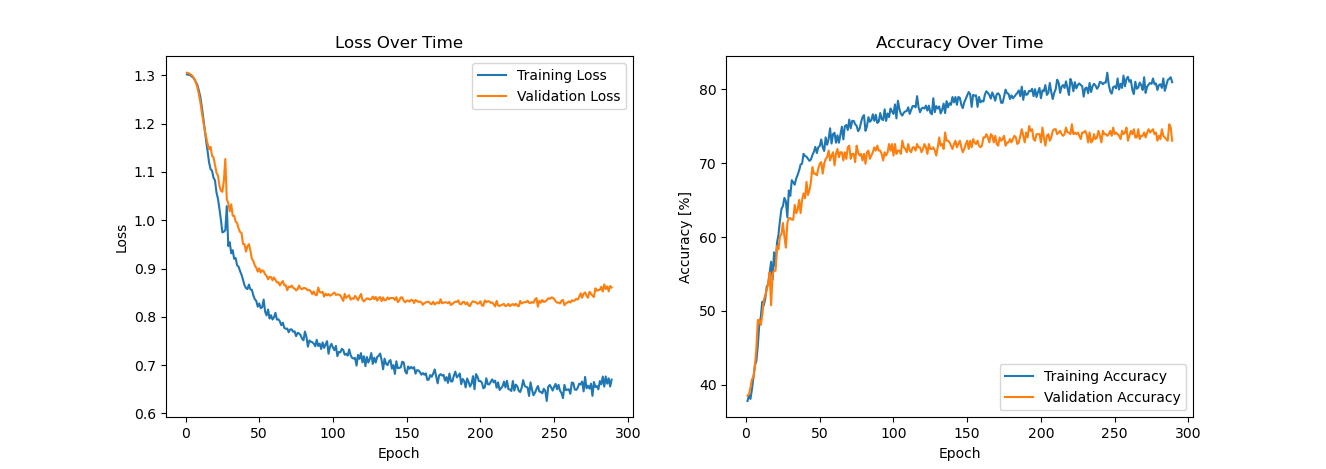

For the Training Dataset.
Training Accuracy: 83.01 %


For the Testing Dataset.
Testing Accuracy: 78.79 %


In [50]:
# Define the layers of the neural network: (minimum of 3 layers)
layers = [12, 2000, 2000, 3]

# Define the activation functions used by each layer:
act_funcs = ['relu', 'softsign', 'softmax'] # Since the input layer has a standard "f(x) = x" activation function, this list has one less element than the "layers" list

# Build and compile the Keras Neural Network:
neural_network = create_neural_net(layers, act_funcs, RProp(eta_minus=0.7, eta_plus=1.5), dropout=0.1, regulizer=l2(0.0001))

# Train the compiled Keras Neural Network:
neural_network = fit_neural_net(neural_network, X_train, y_train, num_batches=1, epochs=500, verbose=1, validation_split=0.2, early_stopping=True, patience=50, plot=True, fignum=2)

# Plot confusion matrices?
plot_conf = False

# Evaluate the model on the training and testing datasets.
print("For the Training Dataset.")
_, training_accuracy = evaluate_model(neural_network, X_train, y_train, fignum=3, plot=plot_conf)
print('Training Accuracy: {:.2f} %'.format(training_accuracy*100))
print('\n')
print("For the Testing Dataset.")
_, testing_accuracy = evaluate_model(neural_network, X_test, y_test, fignum=4, plot=plot_conf)
print('Testing Accuracy: {:.2f} %'.format(testing_accuracy*100))

# Hyperparameter Optimization

Define a function that performs k-fold cross validation

In [51]:
# Define a Function that Performs K-Fold Cross Validation
def neural_net_kfold(X, y, k, models, stratified=False, verbose=[0,1], num_batches=1):
    '''
    This function performs k-fold cross validation on the given dataset.

    Inputs:
        X = The provided input datapoints.
        y = The associated output classifications related to the input datapoints.
        models = A list of "k" nearly identical models (with different weight initialization)
    Outputs:
        average_accuracy = The average accuracy on the testing fold obtained over all k-fold runs.
        accuracy_standard_deviation = The standard deviation in accuracy on the testing fold obtained over all k-fold runs.
        average_loss = The average loss on the testing fold obtained over all k-fold runs.
        loss_standard_deviation = The standard deviation in loss on the testing fold obtained over all k-fold runs.
    '''
    
    # Split the data into seperate folds:
    if stratified:
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
        generator = kf.split(X, np.argmax(y, axis = 1))
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        generator = kf.split(X)

    # Store results for each fold
    fold_accuracy = []
    fold_loss = []

    # Perform k-fold cross-validation
    n = 1
    for train_index, test_index in generator:
        # Split into train and test sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardise the input training and testing folds, based only on the training fold:
        standardizing_scaler = StandardScaler()
        standardizing_scaler.fit(X_train)

        X_train = standardizing_scaler.transform(X_train)
        X_test = standardizing_scaler.transform(X_test)
        
        # Create a new model for each fold (reset the weights)
        model = models[n-1]
        
        # Train the model
        model = fit_neural_net(model, X_train, y_train, epochs=150, verbose=verbose[0], num_batches=num_batches)
        
        # Evaluate the model on the test set for this fold
        loss, accuracy = evaluate_model(model, X_test, y_test)

        # Return the accuracy 
        if verbose[1] == 1:
            print(f"Accuracy for fold {n}: {accuracy * 100:.2f}%")
        
        # Save the accuracy for this fold
        fold_accuracy.append(accuracy)
        fold_loss.append(loss)

        n += 1

    # Convert the lists to a numpy arrays
    fold_accuracy = np.array(fold_accuracy)
    fold_loss = np.array(fold_loss)

    # Find the average and standard deviation of the accuracy of all K-Fold runs.
    average_accuracy = np.mean(fold_accuracy*100)
    accuracy_standard_deviation = np.std(fold_accuracy*100)

    # Find the average and standard deviation of the loss of all K-Fold runs.
    average_loss = np.mean(fold_loss)
    loss_standard_deviation = np.std(fold_loss)

    return average_accuracy, accuracy_standard_deviation, average_loss, loss_standard_deviation

Optimize the number of nodes in each hidden layer

In [19]:
# Define the lists containing the number of nodes per layer
layer1_vals = [10, 50, 100, 500, 1000, 2000]
layer2_vals = [10, 50, 100, 500, 1000, 2000]

m = len(layer1_vals)
n = len(layer2_vals)

# Create empty arrays to store the accuracy and loss values
accuracy_values = np.zeros((m, n))
accuracy_std_values = np.zeros((m, n))
loss_values = np.zeros((m, n))
loss_std_values = np.zeros((m, n))

# Define the activation functions used by each layer:
act_funcs = ['relu', 'relu', 'softmax']

# How many folds should the cross validation use:
k = 10

m = 0
for i in layer1_vals:
    n = 0
    for j in layer2_vals:
        # Define the layers of the neural network: (minimum of 3 layers)
        layers = [12, i, j, 3]

        print('Layers:', layers)

        models = []
        for r in range(k):
            model = create_neural_net(layers, act_funcs, opt=RProp(), dropout=0.5, regulizer=l2(0.001))
            models.append(model)

        
        results = neural_net_kfold(X, y, k, models, stratified=True, verbose=[0,1])

        print("______________________________")

        accuracy_values[m, n] = results[0]
        accuracy_std_values[m, n] = results[1]
        loss_values[m, n] = results[2]
        loss_std_values[m, n] = results[3]

        n += 1
        
    m += 1

Layers: [12, 10, 10, 3]
Accuracy for fold 1: 62.99%
Accuracy for fold 2: 58.36%
Accuracy for fold 3: 54.80%
Accuracy for fold 4: 57.86%
Accuracy for fold 5: 58.21%
Accuracy for fold 6: 56.79%
Accuracy for fold 7: 53.21%
Accuracy for fold 8: 61.79%
Accuracy for fold 9: 60.71%
Accuracy for fold 10: 58.57%
______________________________
Layers: [12, 10, 50, 3]
Accuracy for fold 1: 60.14%
Accuracy for fold 2: 59.43%
Accuracy for fold 3: 54.09%
Accuracy for fold 4: 59.64%
Accuracy for fold 5: 61.07%
Accuracy for fold 6: 61.43%
Accuracy for fold 7: 58.21%
Accuracy for fold 8: 58.93%
Accuracy for fold 9: 59.64%
Accuracy for fold 10: 63.21%
______________________________
Layers: [12, 10, 100, 3]
Accuracy for fold 1: 61.92%
Accuracy for fold 2: 59.07%
Accuracy for fold 3: 54.80%
Accuracy for fold 4: 60.71%
Accuracy for fold 5: 61.43%
Accuracy for fold 6: 64.64%
Accuracy for fold 7: 55.00%
Accuracy for fold 8: 63.93%
Accuracy for fold 9: 59.64%
Accuracy for fold 10: 65.36%
______________________

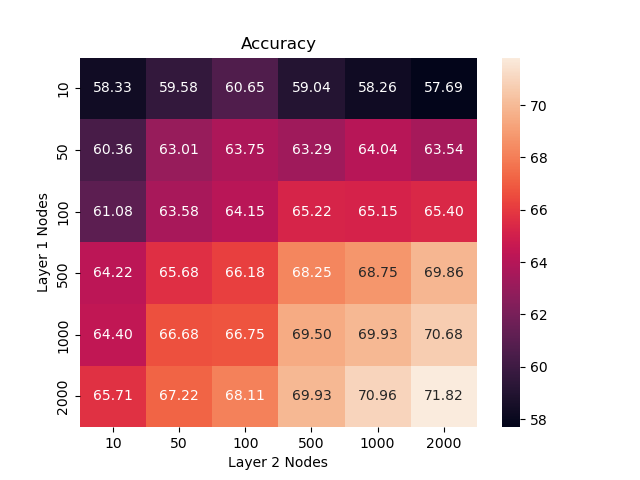

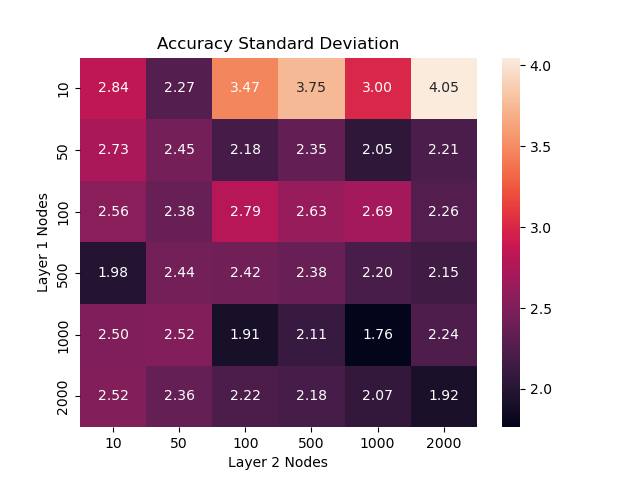

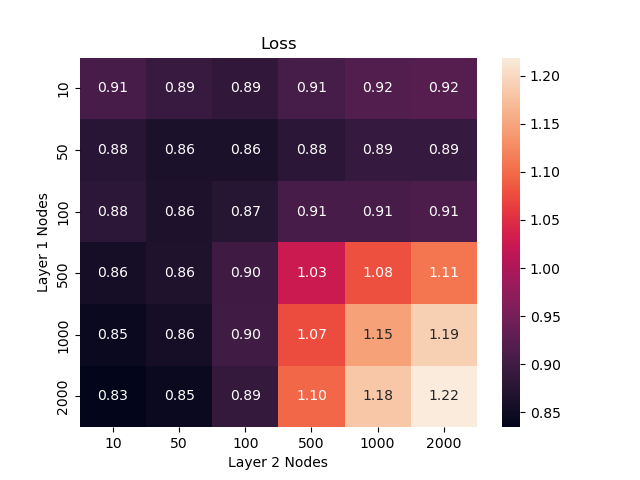

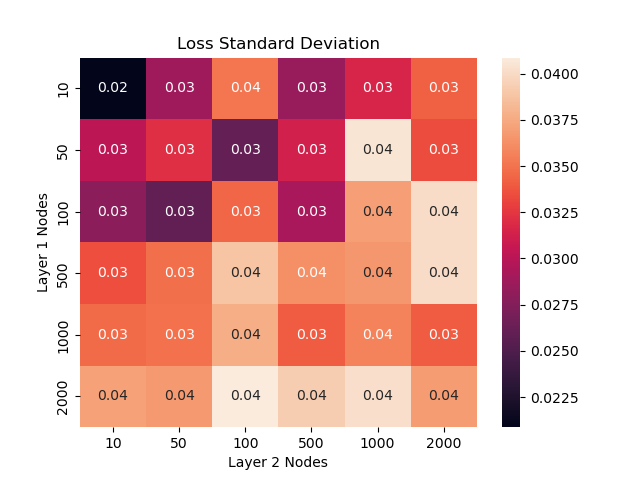

In [25]:
plt.figure(5)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_values, 
                 xticklabels=layer2_vals,
                 yticklabels=layer1_vals,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy")    
plt.xlabel("Layer 2 Nodes")
plt.ylabel("Layer 1 Nodes")
# displaying the plotted heatmap 
plt.savefig('Accuracy.png')
plt.show()

plt.figure(6)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_std_values, 
                 xticklabels=layer2_vals,
                 yticklabels=layer1_vals,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy Standard Deviation")    
plt.xlabel("Layer 2 Nodes")
plt.ylabel("Layer 1 Nodes")
# displaying the plotted heatmap 
plt.savefig('Accuracy_Standard_Deviation.png')
plt.show()

plt.figure(7)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_values, 
                 xticklabels=layer2_vals,
                 yticklabels=layer1_vals,
                 fmt='.2f',
                 annot=True) 
    
plt.title("Loss")
plt.xlabel("Layer 2 Nodes")
plt.ylabel("Layer 1 Nodes")
# displaying the plotted heatmap 
plt.savefig('Loss.png')
plt.show()

plt.figure(8)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_std_values, 
                 xticklabels=layer2_vals,
                 yticklabels=layer1_vals,
                 fmt='.2f',
                 annot=True) 

plt.title("Loss Standard Deviation")
plt.xlabel("Layer 2 Nodes")
plt.ylabel("Layer 1 Nodes")
# displaying the plotted heatmap 
plt.savefig('Loss_Standard_Deviation.png')
plt.show()

Optimize the hidden layer activation functions

In [33]:
# Define the activation functions that can be used by each layer:
act_funcs_layer1 = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'softplus', 'softsign', 'elu', 'selu']
act_funcs_layer2 = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'softplus', 'softsign', 'elu', 'selu']

m = len(act_funcs_layer1)
n = len(act_funcs_layer2)

# Create empty arrays to store the accuracy and loss values
accuracy_values_act = np.zeros((m, n))
accuracy_std_values_act = np.zeros((m, n))
loss_values_act = np.zeros((m, n))
loss_std_values_act = np.zeros((m, n))


# Define the number of nodes per layer:
layers = [12, 100, 100, 3]


# How many folds should the cross validation use:
k = 10

m = 0
for i in act_funcs_layer1:
    n = 0
    for j in act_funcs_layer2:
        # Define the activation functions of the neural network: 
        act_funcs = [i, j, 'softmax']

        print('Activation Functions:', act_funcs)

        models = []
        for r in range(k):
            model = create_neural_net(layers, act_funcs, opt=RProp(), dropout=0.5, regulizer=l2(0.001))
            models.append(model)

        
        results = neural_net_kfold(X, y, k, models, stratified=True, verbose=[0,1])

        print("______________________________")

        accuracy_values_act[m, n] = results[0]
        accuracy_std_values_act[m, n] = results[1]
        loss_values_act[m, n] = results[2]
        loss_std_values_act[m, n] = results[3]

        n += 1
        
    m += 1

Activation Functions: ['sigmoid', 'sigmoid', 'softmax']
Accuracy for fold 1: 52.67%
Accuracy for fold 2: 55.52%
Accuracy for fold 3: 50.89%
Accuracy for fold 4: 55.71%
Accuracy for fold 5: 55.36%
Accuracy for fold 6: 56.79%
Accuracy for fold 7: 51.07%
Accuracy for fold 8: 56.07%
Accuracy for fold 9: 53.93%
Accuracy for fold 10: 58.93%
______________________________
Activation Functions: ['sigmoid', 'tanh', 'softmax']
Accuracy for fold 1: 55.52%
Accuracy for fold 2: 55.87%
Accuracy for fold 3: 51.25%
Accuracy for fold 4: 57.86%
Accuracy for fold 5: 56.43%
Accuracy for fold 6: 58.57%
Accuracy for fold 7: 50.00%
Accuracy for fold 8: 56.43%
Accuracy for fold 9: 57.50%
Accuracy for fold 10: 58.57%
______________________________
Activation Functions: ['sigmoid', 'relu', 'softmax']
Accuracy for fold 1: 53.74%
Accuracy for fold 2: 55.52%
Accuracy for fold 3: 51.96%
Accuracy for fold 4: 51.43%
Accuracy for fold 5: 55.71%
Accuracy for fold 6: 54.29%
Accuracy for fold 7: 43.21%
Accuracy for fold 

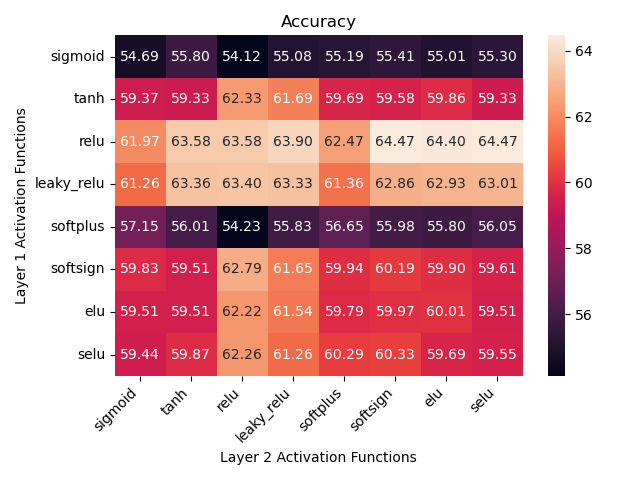

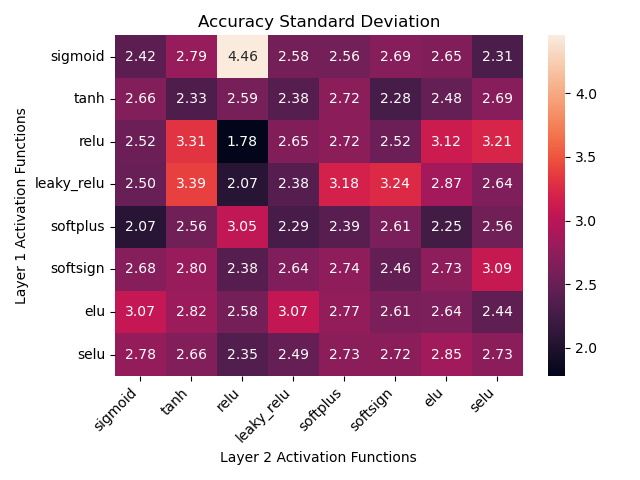

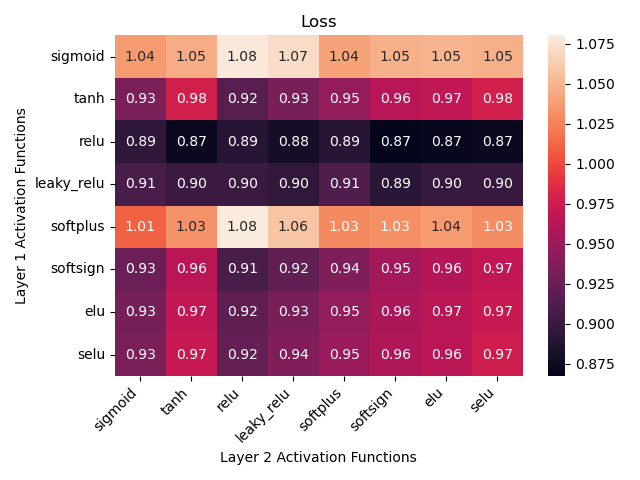

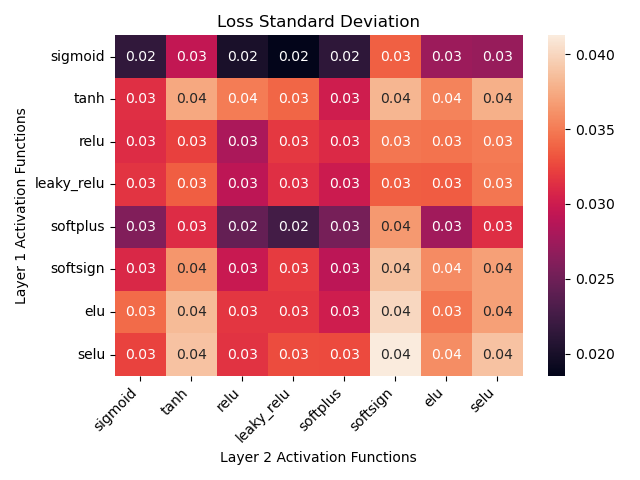

In [36]:
plt.figure(9)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_values_act, 
                 xticklabels=act_funcs_layer2,
                 yticklabels=act_funcs_layer1,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy")    
plt.xlabel("Layer 2 Activation Functions")
plt.ylabel("Layer 1 Activation Functions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy.png')
plt.show()

plt.figure(10)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_std_values_act, 
                 xticklabels=act_funcs_layer2,
                 yticklabels=act_funcs_layer1,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy Standard Deviation")    
plt.xlabel("Layer 2 Activation Functions")
plt.ylabel("Layer 1 Activation Functions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy_Standard_Deviation.png')
plt.show()

plt.figure(11)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_values_act, 
                 xticklabels=act_funcs_layer2,
                 yticklabels=act_funcs_layer1,
                 fmt='.2f',
                 annot=True) 
    
plt.title("Loss")
plt.xlabel("Layer 2 Activation Functions")
plt.ylabel("Layer 1 Activation Functions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss.png')
plt.show()

plt.figure(12)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_std_values_act, 
                 xticklabels=act_funcs_layer2,
                 yticklabels=act_funcs_layer1,
                 fmt='.2f',
                 annot=True) 

plt.title("Loss Standard Deviation")
plt.xlabel("Layer 2 Activation Functions")
plt.ylabel("Layer 1 Activation Functions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss_Standard_Deviation.png')
plt.show()

Optimize the learning rates of the RProp algorithm

In [42]:
# Define the activation functions that can be used by each layer:
eta_plus = [1.01, 1.05, 1.1, 1.2, 1.5, 2]
eta_minus = [0.01, 0.1, 0.5, 0.7, 0.9, 0.99]

m = len(eta_plus)
n = len(eta_minus)

# Create empty arrays to store the accuracy and loss values
accuracy_values_eta = np.zeros((m, n))
accuracy_std_values_eta = np.zeros((m, n))
loss_values_eta = np.zeros((m, n))
loss_std_values_eta = np.zeros((m, n))


# Define the number of nodes per layer:
layers = [12, 300, 300, 3]
# Define the activation functions of the neural network:
act_funcs = ['relu', 'softsign', 'softmax']


# How many folds should the cross validation use:
k = 10

m = 0
for i in eta_plus:
    n = 0
    for j in eta_minus:
        print('Eta Plus:', i)
        print('Eta Minus:', j)
        models = []
        for r in range(k):
            model = create_neural_net(layers, act_funcs, opt=RProp(eta_minus=j, eta_plus=i), dropout=0.5, regulizer=l2(0.001))
            models.append(model)

        
        results = neural_net_kfold(X, y, k, models, stratified=True, verbose=[0,1])

        print("______________________________")

        accuracy_values_eta[m, n] = results[0]
        accuracy_std_values_eta[m, n] = results[1]
        loss_values_eta[m, n] = results[2]
        loss_std_values_eta[m, n] = results[3]

        n += 1
        
    m += 1

Eta Plus: 1.01
Eta Minus: 0.01
Accuracy for fold 1: 35.23%
Accuracy for fold 2: 42.70%
Accuracy for fold 3: 44.48%
Accuracy for fold 4: 38.21%
Accuracy for fold 5: 39.64%
Accuracy for fold 6: 39.64%
Accuracy for fold 7: 31.07%
Accuracy for fold 8: 32.86%
Accuracy for fold 9: 33.93%
Accuracy for fold 10: 28.21%
______________________________
Eta Plus: 1.01
Eta Minus: 0.1
Accuracy for fold 1: 44.13%
Accuracy for fold 2: 46.62%
Accuracy for fold 3: 43.77%
Accuracy for fold 4: 33.21%
Accuracy for fold 5: 36.07%
Accuracy for fold 6: 33.21%
Accuracy for fold 7: 34.29%
Accuracy for fold 8: 42.14%
Accuracy for fold 9: 50.00%
Accuracy for fold 10: 50.00%
______________________________
Eta Plus: 1.01
Eta Minus: 0.5
Accuracy for fold 1: 50.53%
Accuracy for fold 2: 39.86%
Accuracy for fold 3: 25.98%
Accuracy for fold 4: 46.43%
Accuracy for fold 5: 36.43%
Accuracy for fold 6: 50.71%
Accuracy for fold 7: 27.50%
Accuracy for fold 8: 37.86%
Accuracy for fold 9: 31.07%
Accuracy for fold 10: 44.29%
____

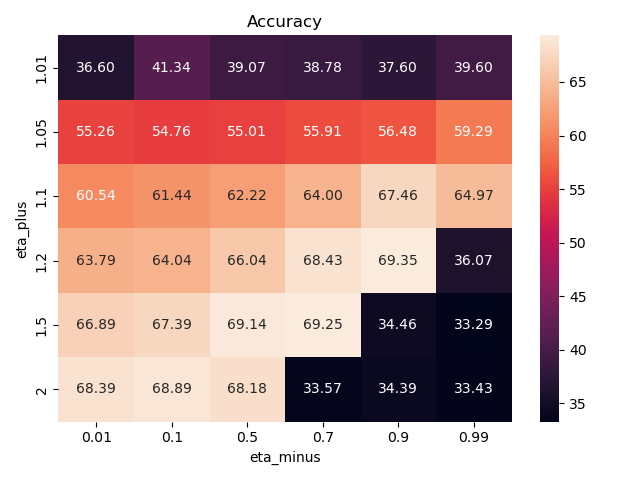

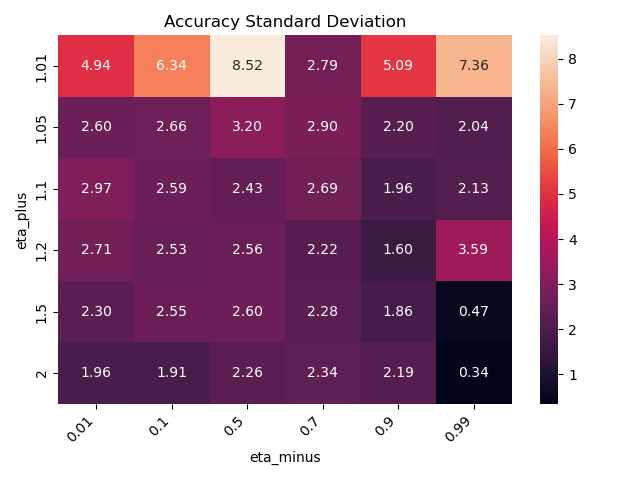

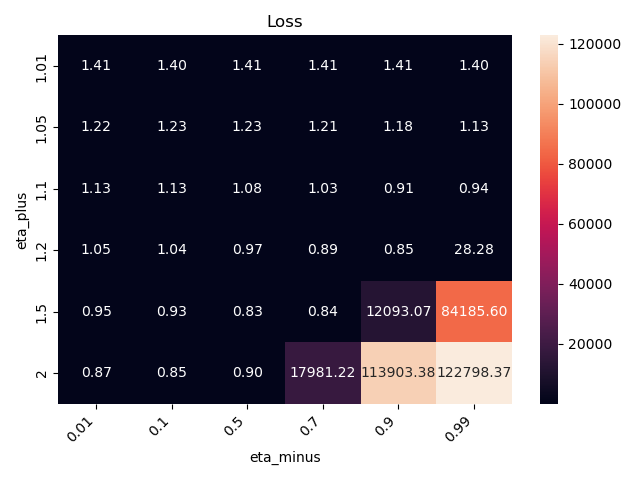

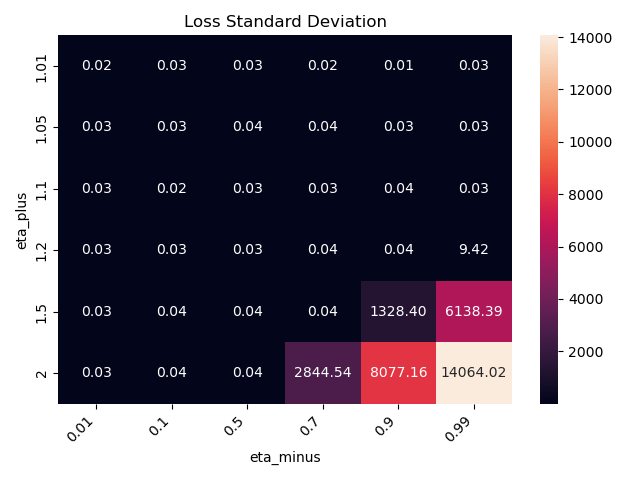

In [45]:
plt.figure(13)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_values_eta, 
                 xticklabels=eta_minus,
                 yticklabels=eta_plus,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy")    
plt.xlabel("eta_minus")
plt.ylabel("eta_plus")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy.png')
plt.show()

plt.figure(14)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_std_values_eta, 
                 xticklabels=eta_minus,
                 yticklabels=eta_plus,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy Standard Deviation")    
plt.xlabel("eta_minus")
plt.ylabel("eta_plus")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy_Standard_Deviation.png')
plt.show()

plt.figure(15)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_values_eta, 
                 xticklabels=eta_minus,
                 yticklabels=eta_plus,
                 fmt='.2f',
                 annot=True) 
    
plt.title("Loss")
plt.xlabel("eta_minus")
plt.ylabel("eta_plus")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss.png')
plt.show()

plt.figure(16)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_std_values_eta, 
                 xticklabels=eta_minus,
                 yticklabels=eta_plus,
                 fmt='.2f',
                 annot=True) 

plt.title("Loss Standard Deviation")
plt.xlabel("eta_minus")
plt.ylabel("eta_plus")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss_Standard_Deviation.png')
plt.show()

Optimize the ADAM optimizer

In [52]:
# Define the activation functions that can be used by each layer:
learning_rate = [0.0001, 0.001, 0.1, 0.5, 1, 1.5]
num_batches = [1, 2, 5, 10, 20, 50]

m = len(learning_rate)
n = len(num_batches)

# Create empty arrays to store the accuracy and loss values
accuracy_values_adam = np.zeros((m, n))
accuracy_std_values_adam = np.zeros((m, n))
loss_values_adam = np.zeros((m, n))
loss_std_values_adam = np.zeros((m, n))


# Define the number of nodes per layer:
layers = [12, 300, 300, 3]
# Define the activation functions of the neural network:
act_funcs = ['relu', 'softsign', 'softmax']


# How many folds should the cross validation use:
k = 10

m = 0
for i in learning_rate:
    n = 0
    for j in num_batches:
        print('Learning Rate:', i)
        print('Number of Mini Batches:', j)
        models = []
        for r in range(k):
            model = create_neural_net(layers, act_funcs, opt=keras.optimizers.Adam(learning_rate=i), dropout=0.5, regulizer=l2(0.001))
            models.append(model)

        
        results = neural_net_kfold(X, y, k, models, stratified=True, verbose=[0,1], num_batches=j)

        print("______________________________")

        accuracy_values_adam[m, n] = results[0]
        accuracy_std_values_adam[m, n] = results[1]
        loss_values_adam[m, n] = results[2]
        loss_std_values_adam[m, n] = results[3]

        n += 1
        
    m += 1

Learning Rate: 0.0001
Number of Mini Batches: 1
Accuracy for fold 1: 61.57%
Accuracy for fold 2: 56.58%
Accuracy for fold 3: 55.16%
Accuracy for fold 4: 60.36%
Accuracy for fold 5: 60.00%
Accuracy for fold 6: 59.64%
Accuracy for fold 7: 55.00%
Accuracy for fold 8: 59.29%
Accuracy for fold 9: 60.71%
Accuracy for fold 10: 62.50%
______________________________
Learning Rate: 0.0001
Number of Mini Batches: 2
Accuracy for fold 1: 64.06%
Accuracy for fold 2: 61.21%
Accuracy for fold 3: 58.72%
Accuracy for fold 4: 55.36%
Accuracy for fold 5: 54.64%
Accuracy for fold 6: 55.71%
Accuracy for fold 7: 46.43%
Accuracy for fold 8: 53.21%
Accuracy for fold 9: 56.43%
Accuracy for fold 10: 55.36%
______________________________
Learning Rate: 0.0001
Number of Mini Batches: 5
Accuracy for fold 1: 60.14%
Accuracy for fold 2: 57.65%
Accuracy for fold 3: 54.45%
Accuracy for fold 4: 59.64%
Accuracy for fold 5: 60.71%
Accuracy for fold 6: 61.79%
Accuracy for fold 7: 55.71%
Accuracy for fold 8: 61.07%
Accuracy

ValueError: Argument `learning_rate` should be float, or an instance of LearningRateSchedule, or a callable (that takes in the current iteration value and returns the corresponding learning rate value). Received instead: learning_rate=1

In [ ]:
plt.figure(17)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_values_adam, 
                 xticklabels=num_batches,
                 yticklabels=learning_rate,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy")    
plt.xlabel("Number of Mini-Batches")
plt.ylabel("Learning Rate")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy.png')
plt.show()

plt.figure(18)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=accuracy_std_values_adam, 
                 xticklabels=num_batches,
                 yticklabels=learning_rate,
                 fmt='.2f',
                 annot=True) 

plt.title("Accuracy Standard Deviation")    
plt.xlabel("Number of Mini-Batches")
plt.ylabel("Learning Rate")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Accuracy_Standard_Deviation.png')
plt.show()

plt.figure(19)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_values_adam, 
                 xticklabels=num_batches,
                 yticklabels=learning_rate,
                 fmt='.2f',
                 annot=True) 
    
plt.title("Loss")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("Learning Rate")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss.png')
plt.show()

plt.figure(20)
plt.clf()
# plotting the heatmap 
hm = sns.heatmap(data=loss_std_values_adam, 
                 xticklabels=num_batches,
                 yticklabels=learning_rate,
                 fmt='.2f',
                 annot=True) 

plt.title("Loss Standard Deviation")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("Learning Rate")
plt.tight_layout()
# displaying the plotted heatmap 
plt.savefig('Loss_Standard_Deviation.png')
plt.show()